In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from psycopg2 import sql
import psycopg2
import os
import matplotlib.pyplot as plt

In [4]:
from model_utils import update_price

update_price(update_db=True)

In [25]:
from sqlalchemy import create_engine


database_url = os.environ["DATABASE_URL"]
engine = create_engine(database_url)

competitor_data_query = """
    product_names AS(
        SELECT DISTINCT product, batch_name
        FROM batchs
    )

    SELECT c.*, b.product FROM competitors c
    LEFT JOIN product_names b ON CAST(c.batch_name AS TEXT) = CAST(b.batch_name AS TEXT)
"""
competitor_data = pd.read_sql_query(competitor_data_query, engine)

(
    competitor_data
    .loc[lambda df: df.execution_time == df.execution_time.max()]
    .assign(
        min_price = lambda df: df
            .loc[lambda df: df.execution_time == df.execution_time.max()]
            .groupby('batch_name')['price']
            .transform("min")
    )
)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column "batch_name" does not exist
LINE 3:         SELECT DISTINCT batch_name FROM stock 
                                ^

[SQL: 
    WITH current_batches AS(
        SELECT DISTINCT batch_name FROM stock 
        WHERE timestamp = MAX(timestamp)
    ),
    product_names AS(
        SELECT DISTINCT product, batch_name
        FROM batchs
    )

    SELECT c.*, b.product FROM competitors c
    LEFT JOIN product_names b ON CAST(c.batch_name AS TEXT) = CAST(b.batch_name AS TEXT)
]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [23]:
min_prices = (
    competitor_data
    .loc[lambda df: df.execution_time == df.execution_time.max()]
    .groupby(['batch_name', 'product'])
    .agg(price = ('price', "min"))
)
min_prices

,,price
batch_name,product,
apples-green_1f8b2f99-5de9-420a-8681-b509e15bb3c0,apples-green,2.12
apples-green_24a75e49-c219-4bf7-888a-7b8d9c6e4c12,apples-green,2.34
apples-green_56293f65-fdc7-4876-9c18-e81e77f2f3f8,apples-green,2.11
apples-green_7e120ad3-0b41-48c6-b306-3785a2d25866,apples-green,2.41
apples-green_86a904c4-494c-41f9-8a49-886a3b8443fc,apples-green,1.40
...,...,...
wine_f5b181df-1c35-4144-9119-a69095339b2b,wine,1.27
wine_f779be55-9aef-445c-96fb-c25cd742908b,wine,4.28
wine_fba507a3-9427-4a7a-851c-836f814cd043,wine,2.54


In [6]:
(
    competitor_data
    .loc[lambda df: df.execution_time == df.execution_time.max()]
    .pivot(
        index=['product', 'batch_name', 'execution_time'], 
        columns='competitor', 
        values='price'
    )
    .reset_index()
    .rename(columns=lambda columns: columns.lower())
    .set_index(['product', 'batch_name'])
    [['dynamicdealmakers', 'gendp', 'redalert', 'random_competitor']]
    .min(axis=1)
    .rename('price')
    .reset_index()
    .assign(price = lambda df: df.price - 0.03)
    .rename(columns={'product': 'product_name'})
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
    .fillna(5)
)

,product_name,batch_name,price
0,apples-green,apples-green_1f8b2f99-5de9-420a-8681-b509e15bb3c0,2.09
1,apples-green,apples-green_24a75e49-c219-4bf7-888a-7b8d9c6e4c12,2.31
2,apples-green,apples-green_56293f65-fdc7-4876-9c18-e81e77f2f3f8,2.08
3,apples-green,apples-green_7e120ad3-0b41-48c6-b306-3785a2d25866,2.38
4,apples-green,apples-green_86a904c4-494c-41f9-8a49-886a3b8443fc,1.37
...,...,...,...
177,wine,wine_f5b181df-1c35-4144-9119-a69095339b2b,1.24
178,wine,wine_f779be55-9aef-445c-96fb-c25cd742908b,4.25
179,wine,wine_fba507a3-9427-4a7a-851c-836f814cd043,2.51
180,wine,wine_fc0d000c-728c-40bf-9b3b-b959eedba798,2.43


In [7]:
from data_utils import load_data, preprocess_data
from model_utils import greedy_epsilon, undercut_min_price

sales_data, price_data, competitor_data = load_data()
df = preprocess_data(sales_data, price_data, competitor_data)
prices_df = undercut_min_price(df)


In [9]:
prices_df

,product_name,batch_name,price
0,rice,rice_01646775-1c4c-4efc-85ba-9ac9f93ee32f,2.76
1,rice,rice_0308046f-6615-4b5c-9a25-20f1a0c856e7,2.46
2,rice,rice_030b015a-9b36-464c-8c50-84c7d8849689,2.68
3,rice,rice_0e5ef432-bfa2-4bba-a7b6-f3406a210ff6,2.44
4,rice,rice_12d05749-9b35-4c2f-b67a-b2da5b43ada3,2.65
...,...,...,...
117,wine,wine_f0190c67-5ca3-4cb3-9edd-df1f5a0ca5e7,3.07
118,wine,wine_f5b181df-1c35-4144-9119-a69095339b2b,1.24
119,wine,wine_fba507a3-9427-4a7a-851c-836f814cd043,2.51
120,wine,wine_fc0d000c-728c-40bf-9b3b-b959eedba798,2.43


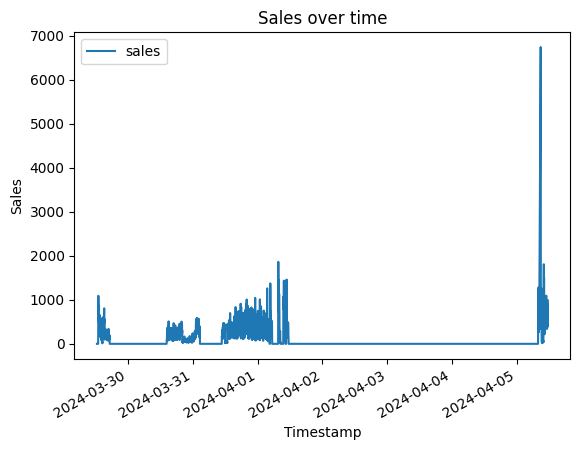

In [262]:
from figures import plot_total_sales

plot_total_sales(df)

In [129]:
df[lambda df: df.timestamp == df.timestamp.max()].stock.sum()

6151

In [198]:
df_last = df[lambda df: df.timestamp == df.timestamp.max()]

df_last.groupby(['product', 'batch_name'])[['dynamicdealmakers', 'gendp', 'redalert', 'random_competitor']].transform("min")

,dynamicdealmakers,gendp,redalert,random_competitor
967252,3.22,5.39,NaN,2.64
967253,4.26,4.54,NaN,2.90
967254,3.52,4.66,NaN,2.44
967255,6.76,4.69,NaN,4.44
967256,3.64,5.69,NaN,3.28
...,...,...,...,...
967420,2.67,3.91,NaN,4.98
967421,2.93,5.31,NaN,1.88
967422,4.20,5.73,NaN,4.99
967423,NaN,NaN,NaN,NaN


In [256]:
def undercut_min_price(df):

    return (
        df
        .loc[lambda df: df.timestamp == df.timestamp.max()]
        .loc[lambda df: df.sell_by > pd.Timestamp.now()]
        .set_index(['product', 'batch_name'])
        [['dynamicdealmakers', 'gendp', 'redalert', 'random_competitor']]
        .min(axis=1)
        .rename('price')
        .reset_index()
        .assign(price = lambda df: df.price - 0.03)
        .rename(columns={'product': 'product_name'})
        .sort_values(['product_name', 'batch_name', 'price'])
        .reset_index(drop=True)
        .fillna(5)
    )


,product_name,batch_name,price
0,rice,rice_01646775-1c4c-4efc-85ba-9ac9f93ee32f,2.96
1,rice,rice_0308046f-6615-4b5c-9a25-20f1a0c856e7,2.67
2,rice,rice_030b015a-9b36-464c-8c50-84c7d8849689,1.54
3,rice,rice_12d05749-9b35-4c2f-b67a-b2da5b43ada3,1.33
4,rice,rice_132f6592-a182-4739-8d7d-ce2a3992bc5c,2.10
...,...,...,...
117,wine,wine_eea83119-e91b-4b76-9041-204c84494fbd,2.17
118,wine,wine_f0190c67-5ca3-4cb3-9edd-df1f5a0ca5e7,1.94
119,wine,wine_f5b181df-1c35-4144-9119-a69095339b2b,1.67
120,wine,wine_fba507a3-9427-4a7a-851c-836f814cd043,1.18


In [242]:
current_batches = sales_data.loc[lambda df: df.sell_by > pd.Timestamp.now()]['batch_name'].unique()
epsilon = 0.35

min_prices = (
    df
    [lambda df: df.timestamp == df.timestamp.max()]
    .set_index(['product', 'batch_name'])
    [['dynamicdealmakers', 'gendp', 'redalert', 'random_competitor']]
    .min(axis=1)
    .rename('price')
    .reset_index()
    .assign(price = lambda df: df.price - 0.03)
    .rename(columns={'product': 'product_name'})
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
    .loc[lambda df: df.batch_name.isin(current_batches)]
)

price_ranges = {
    'rice': (1, 6),
    'wine': (4, 25),
    'apples-red': (1.2, 4),
    'apples-green': (1.2, 4),
    'bananas': (0.9, 3),
    'bananas-organic': (1.5, 3.5),
    'broccoli': (2, 6),
    'cheese': (7, 25),
    'beef': (10, 30),
    'avocado': (4, 12)
}

prices = []
for batch_name in current_batches:
    if batch_name not in min_prices.batch_name:
        product = sales_data.loc[lambda df: df['batch_name'] == batch_name]['product'].values[0]
        if np.random.rand() > epsilon:
            product_df = df.loc[lambda df: df['product'] == product]
            price = product_df.iloc[product_df['sales'].argmax()]['price']
            print(f'product {product}, batch {batch_name}: exploit. setting price to {price} '
                f'which generated the highest sales of {product_df['sales'].max()}')
        else:
            price = np.random.uniform(low=price_ranges[product][0], high=price_ranges[product][1])
            print(f'product {product}, batch {batch_name}: explore. sampling uniformly between '
                f'{price_ranges[product][0]} and {price_ranges[product][1]} eur. setting price to {price}')
        prices.append((product, batch_name, price))

prices_df = (
    pd.DataFrame(prices, columns=['product_name', 'batch_name', 'price'])
    .assign(start_date = pd.Timestamp.now())
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
)



product wine, batch wine_0f395984-f563-42e9-adbf-545e33d99884: explore. sampling uniformly between 4 and 25 eur. setting price to 19.360015152830954
product rice, batch rice_a46dc9db-a20f-4d68-87a1-6e97deaf12cb: explore. sampling uniformly between 1 and 6 eur. setting price to 2.434081792169593
product wine, batch wine_05d388dc-dc6e-43b2-9a71-98cb4464f816: explore. sampling uniformly between 4 and 25 eur. setting price to 13.356022983050794
product rice, batch rice_ce73e293-e799-41c5-bacf-a5b92ba7badf: explore. sampling uniformly between 1 and 6 eur. setting price to 5.771780484147636
product rice, batch rice_0308046f-6615-4b5c-9a25-20f1a0c856e7: exploit. setting price to 5.866698 which generated the highest sales of 293.3349
product wine, batch wine_8f431c7f-0ae7-4997-905d-f007e60130e7: explore. sampling uniformly between 4 and 25 eur. setting price to 10.192310629576582
product wine, batch wine_7b1aa4a1-d970-4cae-8908-6fe0fb8d91fb: explore. sampling uniformly between 4 and 25 eur. se

In [243]:
min_prices

,product_name,batch_name,price
37,rice,rice_01646775-1c4c-4efc-85ba-9ac9f93ee32f,2.96
38,rice,rice_0308046f-6615-4b5c-9a25-20f1a0c856e7,2.67
39,rice,rice_030b015a-9b36-464c-8c50-84c7d8849689,1.54
40,rice,rice_12d05749-9b35-4c2f-b67a-b2da5b43ada3,1.33
41,rice,rice_132f6592-a182-4739-8d7d-ce2a3992bc5c,2.10
...,...,...,...
166,wine,wine_eea83119-e91b-4b76-9041-204c84494fbd,2.17
167,wine,wine_f0190c67-5ca3-4cb3-9edd-df1f5a0ca5e7,1.94
169,wine,wine_f5b181df-1c35-4144-9119-a69095339b2b,1.67
171,wine,wine_fba507a3-9427-4a7a-851c-836f814cd043,1.18


In [238]:
min_prices

,product_name,batch_name,price
37,rice,rice_01646775-1c4c-4efc-85ba-9ac9f93ee32f,2.96
38,rice,rice_0308046f-6615-4b5c-9a25-20f1a0c856e7,2.67
39,rice,rice_030b015a-9b36-464c-8c50-84c7d8849689,1.54
40,rice,rice_12d05749-9b35-4c2f-b67a-b2da5b43ada3,1.33
41,rice,rice_132f6592-a182-4739-8d7d-ce2a3992bc5c,2.10
...,...,...,...
166,wine,wine_eea83119-e91b-4b76-9041-204c84494fbd,2.17
167,wine,wine_f0190c67-5ca3-4cb3-9edd-df1f5a0ca5e7,1.94
169,wine,wine_f5b181df-1c35-4144-9119-a69095339b2b,1.67
171,wine,wine_fba507a3-9427-4a7a-851c-836f814cd043,1.18


In [237]:
prices_df

,product_name,batch_name,price,start_date
0,rice,rice_01646775-1c4c-4efc-85ba-9ac9f93ee32f,5.866698,2024-04-05 12:27:05.760451
1,rice,rice_0308046f-6615-4b5c-9a25-20f1a0c856e7,5.866698,2024-04-05 12:27:05.760451
2,rice,rice_030b015a-9b36-464c-8c50-84c7d8849689,2.312769,2024-04-05 12:27:05.760451
3,rice,rice_12d05749-9b35-4c2f-b67a-b2da5b43ada3,5.123201,2024-04-05 12:27:05.760451
4,rice,rice_132f6592-a182-4739-8d7d-ce2a3992bc5c,5.866698,2024-04-05 12:27:05.760451
...,...,...,...,...
117,wine,wine_eea83119-e91b-4b76-9041-204c84494fbd,24.712046,2024-04-05 12:27:05.760451
118,wine,wine_f0190c67-5ca3-4cb3-9edd-df1f5a0ca5e7,24.712046,2024-04-05 12:27:05.760451
119,wine,wine_f5b181df-1c35-4144-9119-a69095339b2b,22.108321,2024-04-05 12:27:05.760451
120,wine,wine_fba507a3-9427-4a7a-851c-836f814cd043,24.712046,2024-04-05 12:27:05.760451


In [170]:


price_ranges = {
    'rice': (1, 6),
    'wine': (4, 25),
    'apples-red': (1.2, 4),
    'apples-green': (1.2, 4),
    'bananas': (0.9, 3),
    'bananas-organic': (1.5, 3.5),
    'broccoli': (2, 6),
    'cheese': (7, 25),
    'beef': (10, 30),
    'avocado': (4, 12)
}

print(f'epsilon set to {epsilon}, which means we explore {epsilon*100} % of the time')

unique_batch_names = sales_data.loc[lambda df: df.sell_by > pd.Timestamp.now()]['batch_name'].unique()

prices = []
for batch_name in unique_batch_names:
    product = sales_data.loc[lambda df: df['batch_name'] == batch_name]['product'].values[0]
    if np.random.rand() > epsilon:
        product_df = preprocessed_df.loc[lambda df: df['product'] == product]
        price = product_df.iloc[product_df['sales'].argmax()]['price']
        print(f'product {product}, batch {batch_name}: exploit. setting price to {price} '
            f'which generated the highest sales of {product_df['sales'].max()}')
    else:
        price = np.random.uniform(low=price_ranges[product][0], high=price_ranges[product][1])
        print(f'product {product}, batch {batch_name}: explore. sampling uniformly between '
            f'{price_ranges[product][0]} and {price_ranges[product][1]} eur. setting price to {price}')
    prices.append((product, batch_name, price))

prices_df = (
    pd.DataFrame(prices, columns=['product_name', 'batch_name', 'price'])
    .assign(start_date = pd.Timestamp.now())
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
)



NameError: name 'epsilon' is not defined

In [29]:
def get_X_y(df):
    return df.drop(columns='sales'), df['sales']


X, y = (
    preprocessed_df
    .loc[lambda df: df.sales > 0]
    .assign(product = lambda df: df['product'].astype('category'))
    .assign(hours_until_perished = lambda df: (df.timestamp - df.sell_by).dt.seconds / 60 / 60)
    .loc[:, ['sales', 'product', 'hours_until_perished']]
    .pipe(get_X_y)
)

X, y


(             product  hours_until_perished
 166186  apples-green             23.888889
 166404  apples-green             23.921944
 166683  apples-green             23.955278
 166752  apples-green             23.988611
 167089  apples-green             23.855278
 ...              ...                   ...
 961491          wine              2.721667
 961662          wine              2.771667
 961416          wine              2.338889
 961213          wine              1.255000
 962343          wine              0.905278
 
 [9438 rows x 2 columns],
 166186     69.802030
 166404     50.944437
 166683     14.048384
 166752    107.467171
 167089     11.234778
              ...    
 961491    260.211824
 961662     98.848184
 961416    494.240920
 961213     55.250695
 962343    188.116524
 Name: sales, Length: 9438, dtype: float64)

In [51]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate
from models import ridge, gradient_booster

model = gradient_booster.get_model()

cv = KFold(n_splits=5, shuffle=True)

cv_results = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    return_estimator=True
)

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate
from models import ridge, gradient_booster

model = ridge.get_model()

cv = KFold(n_splits=5, shuffle=True)

cv_results = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    return_estimator=True
)

In [19]:
epsilon = 0.35

price_ranges = {
    'rice': (1, 6),
    'wine': (4, 25),
    'apples-red': (1.2, 4),
    'apples-green': (1.2, 4),
    'bananas': (0.9, 3),
    'bananas-organic': (1.5, 3.5),
    'broccoli': (2, 6),
    'cheese': (7, 25),
    'beef': (10, 30),
    'avocado': (4, 12)
}

print(f'epsilon set to {epsilon}, which means we explore {epsilon*100} % of the time')

unique_batch_names = sales_data.loc[lambda df: df.sell_by > pd.Timestamp.now()]['batch_name'].unique()

prices = []
for batch_name in unique_batch_names:
    product = sales_data.loc[lambda df: df['batch_name'] == batch_name]['product'].values[0]
    if np.random.rand() > epsilon:
        product_df = preprocessed_df.loc[lambda df: df['product'] == product]
        price = product_df.iloc[product_df['sales'].argmax()]['price']
        print(f'product {product}, batch {batch_name}: exploit. setting price to {price} '
            f'which generated the highest sales of {product_df['sales'].max()}')
    else:
        price = np.random.uniform(low=price_ranges[product][0], high=price_ranges[product][1])
        print(f'product {product}, batch {batch_name}: explore. sampling uniformly between '
            f'{price_ranges[product][0]} and {price_ranges[product][1]} eur. setting price to {price}')
    prices.append((product, batch_name, price))

prices_df = (
    pd.DataFrame(prices, columns=['product_name', 'batch_name', 'price'])
    .assign(start_date = pd.Timestamp.now())
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
)

In [95]:
product_df

,batch_id,batch_name,timestamp,product,sell_by,stock,product_name,price,start_date,stock_diff,sales
44076,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:30:18.384139,wine,2024-03-25 17:40:01.257532,20,rice,5.706182,2024-03-25 17:29:41.390939,-0.0,-0.0
44282,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:31:33.088477,wine,2024-03-25 17:40:01.257532,20,rice,2.491369,2024-03-25 17:30:57.129940,-0.0,-0.0
44403,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:32:48.077251,wine,2024-03-25 17:40:01.257532,20,rice,5.624093,2024-03-25 17:32:11.713449,-0.0,-0.0
44591,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:34:03.697897,wine,2024-03-25 17:40:01.257532,20,rice,5.605772,2024-03-25 17:33:26.517942,-0.0,-0.0
44868,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:35:20.131334,wine,2024-03-25 17:40:01.257532,20,rice,4.247642,2024-03-25 17:34:42.976510,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
171505,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 13:57:20.361049,wine,2024-03-30 13:50:01.065698,20,wine,18.829960,2024-03-29 13:56:09.004270,-0.0,-0.0
171684,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 13:59:19.800596,wine,2024-03-30 13:50:01.065698,20,wine,9.062145,2024-03-29 13:58:07.956468,-0.0,-0.0
171905,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 14:01:19.902496,wine,2024-03-30 13:50:01.065698,20,wine,24.445082,2024-03-29 14:00:05.099709,-0.0,-0.0
172035,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 14:03:19.853920,wine,2024-03-30 13:50:01.065698,20,wine,9.623322,2024-03-29 14:02:05.125136,-0.0,-0.0


In [ ]:
linspa0.80

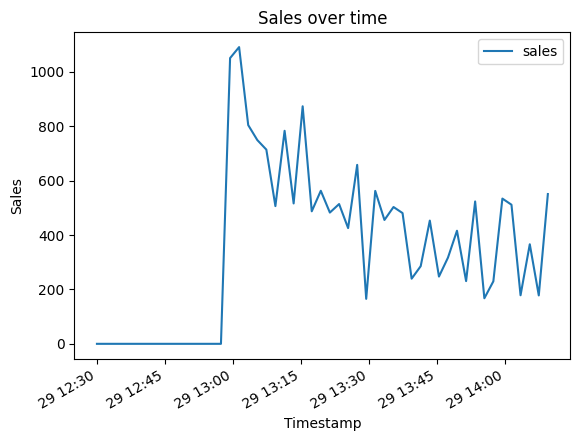

In [33]:
# def plot_total_sales()
    

plot = preprocessed_df.loc[lambda df: df.timestamp > "2024-03-29 12:30:00"].groupby('timestamp').agg(sales = ('sales', 'sum')).plot(title="Sales over time", ylabel="Sales", xlabel="Timestamp")


In [38]:
plot

<Axes: title={'center': 'Sales over time'}, xlabel='Timestamp', ylabel='Sales'>

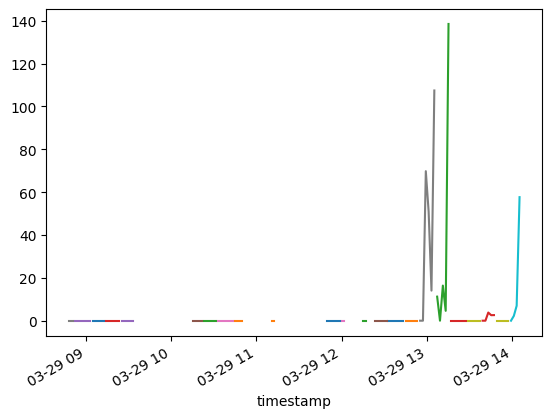

In [7]:
(
    preprocessed_df
    .loc[lambda df: df.timestamp > "2024-03-28 13:00:00"]
    .drop_duplicates("timestamp")
    .pivot(index="timestamp", columns="batch_name", values="sales")
    .plot(legend=False)
)
plt.show()

In [90]:
preprocessed_df.plot(x='timestamp', y='sales', by)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [18]:
epsilon=0.5

price_ranges = {
    'rice': (1, 6),
    'wine': (4, 25),
    'apples-red': (1.2, 4),
    'apples-green': (1.2, 4),
    'bananas': (0.9, 3),
    'bananas-organic': (1.5, 3.5),
    'broccoli': (2, 6),
    'cheese': (7, 25),
    'beef': (10, 30),
    'avocado': (4, 12)
}

print(f'epsilon set to {epsilon}, which means we explore {epsilon*100} % of the time')

unique_batch_names = sales_data.loc[lambda df: df.sell_by > pd.Timestamp.now()]['batch_name'].unique()

prices = []
for batch_name in unique_batch_names:
    product = sales_data.loc[lambda df: df['batch_name'] == batch_name]['product'].values[0]
    if np.random.rand() > epsilon:
        product_df = preprocessed_df.loc[lambda df: df['product'] == product]
        price = product_df.iloc[product_df['sales'].argmax()]['price']
        print(f'product {product}, batch {batch_name}: exploit. setting price to {price} '
              f'which generated the highest sales of {product_df['sales'].max()}')
    else:
        price = np.random.uniform(low=price_ranges[product][0], high=price_ranges[product][1])
        print(f'product {product}, batch {batch_name}: explore. sampling uniformly between '
            f'{price_ranges[product][0]} and {price_ranges[product][1]} eur. setting price to {price}')
    prices.append((product, batch_name, price))

prices_df = (
    pd.DataFrame(prices, columns=['product_name', 'batch_name', 'price'])
    .assign(start_date = pd.Timestamp.now())
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
)

prices_df


epsilon set to 0.5, which means we explore 50.0 % of the time
product rice, batch rice_e97cd306-6775-4761-a1ea-54b52560771b: explore. sampling uniformly between 1 and 6 eur. setting price to 1.870963454180601
product rice, batch rice_849715db-37b9-4b5c-bafd-f1b923d67d89: explore. sampling uniformly between 1 and 6 eur. setting price to 5.079551835203385
product rice, batch rice_01966581-75db-47c1-beaa-ae11e7a053f8: explore. sampling uniformly between 1 and 6 eur. setting price to 4.355656459745765
product rice, batch rice_9f5a1344-78a5-46fb-89fd-6aad3006f735: explore. sampling uniformly between 1 and 6 eur. setting price to 1.969837600396939
product rice, batch rice_d43cbd3b-20b7-4523-8931-638230e19281: exploit. setting price to 4.8459797 which generated the highest sales of 198.6851677
product rice, batch rice_28451972-8fe8-4215-b2cf-6034c7965cb9: exploit. setting price to 4.8459797 which generated the highest sales of 198.6851677
product rice, batch rice_ed9e5823-f12b-490a-8517-58682

,product_name,batch_name,price,start_date
0,rice,rice_01966581-75db-47c1-beaa-ae11e7a053f8,4.355656,2024-03-29 15:09:57.699046
1,rice,rice_04c4ae06-240b-4198-b21f-c6756002be51,4.414476,2024-03-29 15:09:57.699046
2,rice,rice_07d476e6-10bf-4e24-8ddc-ea51c4a2cf7c,2.471709,2024-03-29 15:09:57.699046
3,rice,rice_0b5af15c-8045-4f55-a2f2-3589857a26c8,4.845980,2024-03-29 15:09:57.699046
4,rice,rice_0d5e0bd9-1949-448b-a47c-2c850fd779bd,1.089079,2024-03-29 15:09:57.699046
...,...,...,...,...
125,wine,wine_f4bc7e58-2910-433c-91d7-03a44001ae9d,13.201811,2024-03-29 15:09:57.699046
126,wine,wine_f7f43c93-5657-46a8-8beb-eabb778b4c12,24.712046,2024-03-29 15:09:57.699046
127,wine,wine_fa2e5c67-e215-440c-a05e-a7f0f4786729,8.343557,2024-03-29 15:09:57.699046
128,wine,wine_feceb5d6-e4d0-4689-ac9d-19197b46d768,7.016034,2024-03-29 15:09:57.699046
